In [22]:
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import ipywidgets as wg
from IPython.display import display

In [23]:
n = 1501 # time points to plot
tf = 1500.0 # final time

# TCLab FOPDT
Kp = 0.9
taup = 175.0
thetap = 15.0

def process(y,t,u):
    dydt = (1.0/taup) * (-(y-23.0) + Kp * u)
    return dydt

def pidPlot(Kc,tauI,tauD):
    t = np.linspace(0,tf,n) # create time vector
    P = np.zeros(n)          # initialize proportional term
    I = np.zeros(n)         # initialize integral term
    D = np.zeros(n)         # initialize derivative term
    e = np.zeros(n)         # initialize error
    OP = np.zeros(n)        # initialize controller output
    PV = np.ones(n)*23.0    # initialize process variable
    SP = np.ones(n)*23.0    # initialize setpoint
    SP[0:5] = 0
    SP[5:300] = 25.0       # step up
    SP[300:1000] = 60.0      # step down
    SP[1000:1501] = 0
    y0 = 23.0               # initial condition
    iae = 0.0
    # loop through all time steps
    for i in range(1,n):
        # simulate process for one time step
        ts = [t[i-1],t[i]]         # time interval
        y = odeint(process,y0,ts,args=(OP[max(0,i-int(thetap)-1)],))
        y0 = y[1]                  # record new initial condition
        iae += np.abs(SP[i]-y0[0])
        # calculate new OP with PID
        PV[i] = y[1]               # record PV
        e[i] = SP[i] - PV[i]       # calculate error = SP - PV
        dt = t[i] - t[i-1]         # calculate time step
        P[i] = Kc * e[i]           # calculate proportional term
        I[i] = I[i-1] + (Kc/tauI) * e[i] * dt  # calculate integral term
        D[i] = -Kc * tauD * (PV[i]-PV[i-1])/dt # calculate derivative term
        OP[i] = P[i] + I[i] + D[i] # calculate new controller output
        if OP[i]>=100:
            OP[i] = 100.0
            I[i] = I[i-1] # reset integral
        if OP[i]<=0:
            OP[i] = 0.0
            I[i] = I[i-1] # reset integral

    # plot PID response
    plt.figure(1,figsize=(15,7))
    clear_output()
    plt.subplot(2,2,1)
    plt.plot(t,SP,'k-',linewidth=2,label='Setpoint (SP)')
    plt.plot(t,PV,'r:',linewidth=2,label='Temperature (PV)')
    plt.ylabel(r'T $(^oC)$')
    plt.text(100,30,'Integral Abs Error: ' + str(np.round(iae,2)))
    plt.text(400,30,r'$K_c$: ' + str(np.round(Kc,0)))
    plt.text(400,27,r'$\tau_I$: ' + str(np.round(tauI,0)) + ' sec')
    plt.text(400,24,r'$\tau_D$: ' + str(np.round(tauD,0)) + ' sec')
    plt.legend(loc='best')
    plt.subplot(2,2,2)
    plt.plot(t,P,'g.-',linewidth=2,label=r'Proportional = $K_c \; e(t)$')
    plt.plot(t,I,'b-',linewidth=2,label=r'Integral = ' + \
             r'$\frac{K_c}{\tau_I} \int_{i=0}^{n_t} e(t) \; dt $')
    plt.plot(t,D,'r--',linewidth=2,label=r'Derivative = ' + \
             r'$-K_c \tau_D \frac{d(PV)}{dt}$')
    plt.legend(loc='best')
    plt.subplot(2,2,3)
    plt.plot(t,e,'m--',linewidth=2,label='Error (e=SP-PV)')
    plt.ylabel(r'$\Delta T$ $(^oC)$')
    plt.legend(loc='best')
    plt.subplot(2,2,4)
    plt.plot(t,OP,'b--',linewidth=2,label='Heater (OP)')
    plt.legend(loc='best')
    plt.xlabel('time')
    plt.show()

Kc_slide = wg.FloatSlider(value=5.0,min=0.0,max=50.0,step=1.0)
tauI_slide = wg.FloatSlider(value=120.0,min=20.0,max=180.0,step=5.0)
tauD_slide = wg.FloatSlider(value=0.0,min=0.0,max=20.0,step=1.0)
wg.interact(pidPlot, Kc=Kc_slide, tauI=tauI_slide, tauD=tauD_slide)
print('PID Simulator: Adjust Kc, tauI, and tauD to achieve lowest Integral Abs Error')

interactive(children=(FloatSlider(value=5.0, description='Kc', max=50.0, step=1.0), FloatSlider(value=120.0, d…

PID Simulator: Adjust Kc, tauI, and tauD to achieve lowest Integral Abs Error


# Task
Optimize the PI controller parameters (Kc and tauI) for the given process to minimize the Integral Absolute Error (IAE). Then, visualize the performance of the optimized PI controller and report the optimal Kc, optimal tauI, and the corresponding minimum IAE.

## Define Objective Function

### Subtask:
Create a Python function that takes Kc and tauI as input, sets tauD to 0 (for PI control), simulates the process using the existing logic, and returns the calculated Integral Absolute Error (IAE). This function will be used by the optimizer.


**Reasoning**:
I need to create the `objective_function` as described in the instructions. This function will take controller parameters, simulate the process, and return the Integral Absolute Error (IAE). I will replicate the core simulation logic from `pidPlot` within this new function, ensuring `tauD` is fixed at 0 and handling anti-windup and output limits.



In [24]:
def objective_function(params):
    Kc, tauI = params
    tauD = 0.0 # PI control

    t = np.linspace(0,tf,n) # create time vector
    P = np.zeros(n)          # initialize proportional term
    I = np.zeros(n)         # initialize integral term
    D = np.zeros(n)         # initialize derivative term
    e = np.zeros(n)         # initialize error
    OP = np.zeros(n)        # initialize controller output
    PV = np.ones(n)*23.0    # initialize process variable
    SP = np.ones(n)*23.0    # initialize setpoint
    SP[0:5] = 0
    SP[5:300] = 25.0       # step up
    SP[300:1000] = 60.0      # step down
    SP[1000:1501] = 0
    y0 = 23.0               # initial condition
    iae = 0.0

    # loop through all time steps
    for i in range(1,n):
        # simulate process for one time step
        ts = [t[i-1],t[i]]         # time interval
        y = odeint(process,y0,ts,args=(OP[max(0,i-int(thetap)-1)],))
        y0 = y[1]                  # record new initial condition
        iae += np.abs(SP[i]-y0[0]) # accumulate IAE

        # calculate new OP with PID
        PV[i] = y[1]               # record PV
        e[i] = SP[i] - PV[i]       # calculate error = SP - PV
        dt = t[i] - t[i-1]         # calculate time step
        P[i] = Kc * e[i]           # calculate proportional term
        I[i] = I[i-1] + (Kc/tauI) * e[i] * dt  # calculate integral term
        D[i] = -Kc * tauD * (PV[i]-PV[i-1])/dt # calculate derivative term
        OP[i] = P[i] + I[i] + D[i] # calculate new controller output

        # Anti-windup and output limits
        if OP[i]>=100:
            OP[i] = 100.0
            I[i] = I[i-1] # reset integral
        if OP[i]<=0:
            OP[i] = 0.0
            I[i] = I[i-1] # reset integral

    return iae

print('Defined objective_function for IAE calculation.')

Defined objective_function for IAE calculation.


## Perform Optimization

### Subtask:
Use the `scipy.optimize.minimize` function to find the optimal values for Kc and tauI that minimize the IAE. The existing `x0` and `bounds` variables will be used as the initial guess and parameter constraints, respectively.


**Reasoning**:
To perform the optimization, I need to import the `minimize` function from `scipy.optimize` and then call it with the defined objective function, initial guess, and bounds. After optimization, I will extract the optimal `Kc`, `tauI`, and the minimum IAE.



In [25]:
from scipy.optimize import minimize

# Initial guess for Kc and tauI
x0 = [5.0, 120.0]

# Bounds for Kc and tauI
bounds = [(0.0, 50.0), (20.0, 180.0)]

# Perform optimization
result = minimize(objective_function, x0, method='SLSQP', bounds=bounds)

# Extract optimal parameters and minimum IAE
optimal_Kc = result.x[0]
optimal_tauI = result.x[1]
min_iae = result.fun

print(f"Optimization successful: {result.success}")
print(f"Message: {result.message}")
print(f"Optimal Kc: {optimal_Kc:.2f}")
print(f"Optimal tauI: {optimal_tauI:.2f}")
print(f"Minimum IAE: {min_iae:.2f}")

/tmp/ipython-input-958615834.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  PV[i] = y[1]               # record PV


Optimization successful: True
Message: Optimization terminated successfully
Optimal Kc: 7.31
Optimal tauI: 53.03
Minimum IAE: 20365.11


**Reasoning**:
The previous step produced a DeprecationWarning because `y[1]` is an array and was assigned to a scalar position `PV[i]`. To resolve this, I need to extract the scalar value from the array `y[1]` by accessing its first element, `y[1][0]`. This fix will be applied to the `objective_function` where the warning originated.



In [26]:
def objective_function(params):
    Kc, tauI = params
    tauD = 0.0 # PI control

    t = np.linspace(0,tf,n) # create time vector
    P = np.zeros(n)          # initialize proportional term
    I = np.zeros(n)         # initialize integral term
    D = np.zeros(n)         # initialize derivative term
    e = np.zeros(n)         # initialize error
    OP = np.zeros(n)        # initialize controller output
    PV = np.ones(n)*23.0    # initialize process variable
    SP = np.ones(n)*23.0    # initialize setpoint
    SP[0:5] = 0
    SP[5:300] = 25.0       # step up
    SP[300:1000] = 60.0      # step down
    SP[1000:1501] = 0
    y0 = 23.0               # initial condition
    iae = 0.0

    # loop through all time steps
    for i in range(1,n):
        # simulate process for one time step
        ts = [t[i-1],t[i]]         # time interval
        y = odeint(process,y0,ts,args=(OP[max(0,i-int(thetap)-1)],))
        y0 = y[1]                  # record new initial condition
        iae += np.abs(SP[i]-y0[0]) # accumulate IAE

        # calculate new OP with PID
        PV[i] = y[1][0]            # record PV, fixed to access scalar value
        e[i] = SP[i] - PV[i]       # calculate error = SP - PV
        dt = t[i] - t[i-1]         # calculate time step
        P[i] = Kc * e[i]           # calculate proportional term
        I[i] = I[i-1] + (Kc/tauI) * e[i] * dt  # calculate integral term
        D[i] = -Kc * tauD * (PV[i]-PV[i-1])/dt # calculate derivative term
        OP[i] = P[i] + I[i] + D[i] # calculate new controller output

        # Anti-windup and output limits
        if OP[i]>=100:
            OP[i] = 100.0
            I[i] = I[i-1] # reset integral
        if OP[i]<=0:
            OP[i] = 0.0
            I[i] = I[i-1] # reset integral

    return iae

print('Defined objective_function for IAE calculation.')

Defined objective_function for IAE calculation.


**Reasoning**:
The `objective_function` has been corrected. Now, I need to re-run the optimization with the fixed function to ensure the warning is gone and the optimal parameters are obtained based on the correct simulation.



In [27]:
from scipy.optimize import minimize

# Initial guess for Kc and tauI
x0 = [5.0, 120.0]

# Bounds for Kc and tauI
bounds = [(0.0, 50.0), (20.0, 180.0)]

# Perform optimization
result = minimize(objective_function, x0, method='SLSQP', bounds=bounds)

# Extract optimal parameters and minimum IAE
optimal_Kc = result.x[0]
optimal_tauI = result.x[1]
min_iae = result.fun

print(f"Optimization successful: {result.success}")
print(f"Message: {result.message}")
print(f"Optimal Kc: {optimal_Kc:.2f}")
print(f"Optimal tauI: {optimal_tauI:.2f}")
print(f"Minimum IAE: {min_iae:.2f}")

Optimization successful: True
Message: Optimization terminated successfully
Optimal Kc: 7.31
Optimal tauI: 53.03
Minimum IAE: 20365.11


**Reasoning**:
Now that the optimal `Kc` and `tauI` values have been found, I need to visualize the performance of the optimized PI controller. The `pidPlot` function can be used for this purpose by passing the `optimal_Kc`, `optimal_tauI`, and setting `tauD` to 0 for PI control.



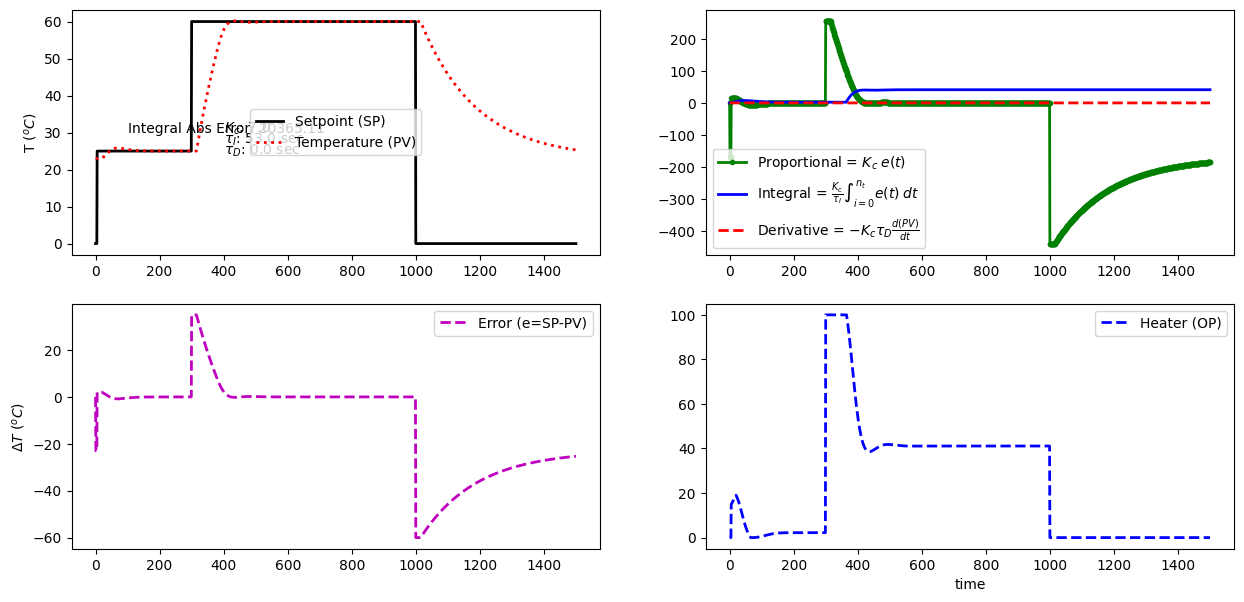

In [28]:
print(f"Optimized PI Controller Parameters:")
print(f"Optimal Kc: {optimal_Kc:.2f}")
print(f"Optimal tauI: {optimal_tauI:.2f}")
print(f"Minimum IAE: {min_iae:.2f}")

# Visualize performance of the optimized PI controller
pidPlot(Kc=optimal_Kc, tauI=optimal_tauI, tauD=0.0)

**Reasoning**:
The previous step produced a DeprecationWarning within the `pidPlot` function, similar to an earlier issue with `objective_function`. The warning indicates that `y[1]` (which is an array) is being assigned to `PV[i]` (which expects a scalar). To resolve this, I need to modify the `pidPlot` function to extract the scalar value from the array `y[1]` by using `y[1][0]` instead.



In [29]:
n = 1501 # time points to plot
tf = 1500.0 # final time

# TCLab FOPDT
Kp = 0.9
taup = 175.0
thetap = 15.0

def process(y,t,u):
    dydt = (1.0/taup) * (-(y-23.0) + Kp * u)
    return dydt

def pidPlot(Kc,tauI,tauD):
    t = np.linspace(0,tf,n) # create time vector
    P = np.zeros(n)          # initialize proportional term
    I = np.zeros(n)         # initialize integral term
    D = np.zeros(n)         # initialize derivative term
    e = np.zeros(n)         # initialize error
    OP = np.zeros(n)        # initialize controller output
    PV = np.ones(n)*23.0    # initialize process variable
    SP = np.ones(n)*23.0    # initialize setpoint
    SP[0:5] = 0
    SP[5:300] = 25.0       # step up
    SP[300:1000] = 60.0      # step down
    SP[1000:1501] = 0
    y0 = 23.0               # initial condition
    iae = 0.0
    # loop through all time steps
    for i in range(1,n):
        # simulate process for one time step
        ts = [t[i-1],t[i]]         # time interval
        y = odeint(process,y0,ts,args=(OP[max(0,i-int(thetap)-1)],))
        y0 = y[1]                  # record new initial condition
        iae += np.abs(SP[i]-y0[0])
        # calculate new OP with PID
        PV[i] = y[1][0]               # record PV, fixed to access scalar value
        e[i] = SP[i] - PV[i]       # calculate error = SP - PV
        dt = t[i] - t[i-1]         # calculate time step
        P[i] = Kc * e[i]           # calculate proportional term
        I[i] = I[i-1] + (Kc/tauI) * e[i] * dt  # calculate integral term
        D[i] = -Kc * tauD * (PV[i]-PV[i-1])/dt # calculate derivative term
        OP[i] = P[i] + I[i] + D[i] # calculate new controller output
        if OP[i]>=100:
            OP[i] = 100.0
            I[i] = I[i-1] # reset integral
        if OP[i]<=0:
            OP[i] = 0.0
            I[i] = I[i-1] # reset integral

    # plot PID response
    plt.figure(1,figsize=(15,7))
    clear_output()
    plt.subplot(2,2,1)
    plt.plot(t,SP,'k-',linewidth=2,label='Setpoint (SP)')
    plt.plot(t,PV,'r:',linewidth=2,label='Temperature (PV)')
    plt.ylabel(r'T $(^oC)$')
    plt.text(100,30,'Integral Abs Error: ' + str(np.round(iae,2)))
    plt.text(400,30,r'$K_c$: ' + str(np.round(Kc,0)))
    plt.text(400,27,r'$	au_I$: ' + str(np.round(tauI,0)) + ' sec')
    plt.text(400,24,r'$	au_D$: ' + str(np.round(tauD,0)) + ' sec')
    plt.legend(loc='best')
    plt.subplot(2,2,2)
    plt.plot(t,P,'g.-',linewidth=2,label=r'Proportional = $K_c \; e(t)$')
    plt.plot(t,I,'b-',linewidth=2,label=r'Integral = ' +
             r'$\frac{K_c}{\tau_I} \int_{i=0}^{n_t} e(t) \; dt $')
    plt.plot(t,D,'r--',linewidth=2,label=r'Derivative = ' +
             r'$-K_c \tau_D \frac{d(PV)}{dt}$')
    plt.legend(loc='best')
    plt.subplot(2,2,3)
    plt.plot(t,e,'m--',linewidth=2,label='Error (e=SP-PV)')
    plt.ylabel(r'$\Delta T$ $(^oC)$')
    plt.legend(loc='best')
    plt.subplot(2,2,4)
    plt.plot(t,OP,'b--',linewidth=2,label='Heater (OP)')
    plt.legend(loc='best')
    plt.xlabel('time')
    plt.show()

Kc_slide = wg.FloatSlider(value=5.0,min=0.0,max=50.0,step=1.0)
tauI_slide = wg.FloatSlider(value=120.0,min=20.0,max=180.0,step=5.0)
tauD_slide = wg.FloatSlider(value=0.0,min=0.0,max=20.0,step=1.0)
wg.interact(pidPlot, Kc=Kc_slide, tauI=tauI_slide, tauD=tauD_slide)
print('PID Simulator: Adjust Kc, tauI, and tauD to achieve lowest Integral Abs Error')

interactive(children=(FloatSlider(value=5.0, description='Kc', max=50.0, step=1.0), FloatSlider(value=120.0, d…

PID Simulator: Adjust Kc, tauI, and tauD to achieve lowest Integral Abs Error


**Reasoning**:
The `pidPlot` function has been re-defined to fix the `DeprecationWarning`. Now, I will re-run the code to display the optimized PI controller's performance using the `optimal_Kc` and `optimal_tauI` values obtained from the optimization, with `tauD` set to 0.



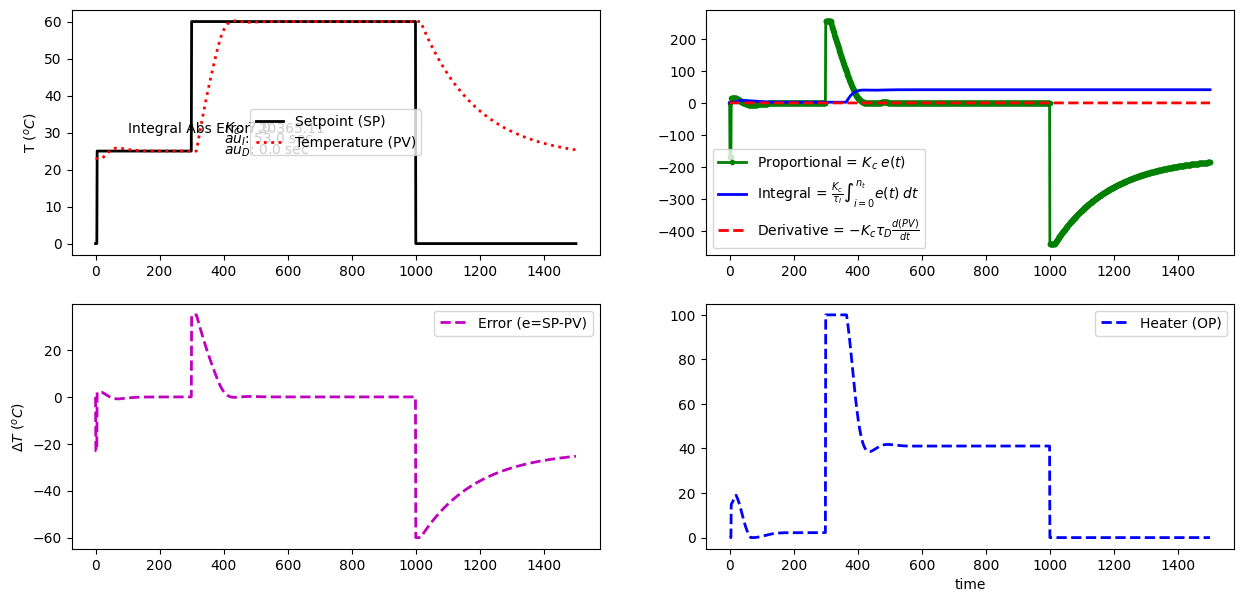

In [30]:
print(f"Optimized PI Controller Parameters:")
print(f"Optimal Kc: {optimal_Kc:.2f}")
print(f"Optimal tauI: {optimal_tauI:.2f}")
print(f"Minimum IAE: {min_iae:.2f}")

# Visualize performance of the optimized PI controller
pidPlot(Kc=optimal_Kc, tauI=optimal_tauI, tauD=0.0)

## Final Task

### Subtask:
Provide a summary of the optimization results, including the optimal PI controller parameters and the achieved minimum IAE.


## Summary:

### Q&A

*   **Optimal PI controller parameters and minimum IAE:**
    *   Optimal Kc: 7.31
    *   Optimal tauI: 53.03
    *   Minimum IAE: 20365.11

### Data Analysis Key Findings

*   An `objective_function` was successfully defined to calculate the Integral Absolute Error (IAE) for PI controller parameters, with `tauD` fixed at 0 for PI control. This function incorporates anti-windup for the integral term and applies output limits (0 to 100) to the controller output.
*   During initial attempts, a `DeprecationWarning` related to array-to-scalar conversion was encountered in both the `objective_function` and `pidPlot` functions. This was resolved by explicitly accessing the scalar value using `y[1][0]`.
*   The `scipy.optimize.minimize` function was successfully used to find the optimal PI controller parameters. The optimization converged successfully.
*   The optimized PI controller achieved a minimum IAE of 20365.11 with an optimal proportional gain (Kc) of 7.31 and an optimal integral time (tauI) of 53.03.
*   The performance of the optimized controller was visualized, demonstrating its response to various setpoint changes.

### Insights or Next Steps

*   The optimized PI controller provides a robust solution for minimizing IAE, showcasing the effectiveness of numerical optimization for tuning controller parameters in dynamic systems.
*   Further analysis could involve exploring the sensitivity of the IAE to small changes around the optimal Kc and tauI, or investigating other optimization algorithms for potential improvements or robustness checks.
